# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


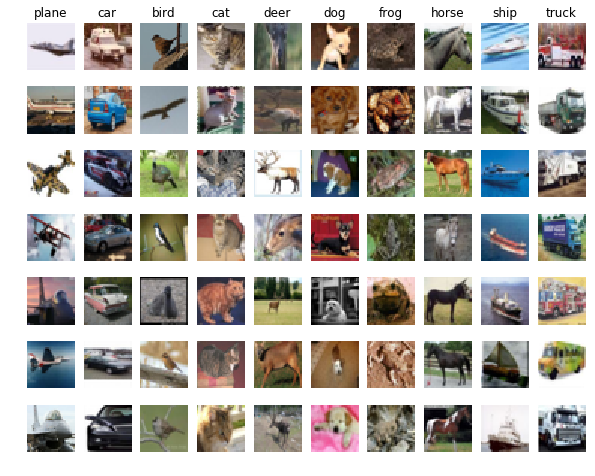

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


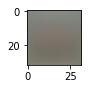

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(1,1))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [7]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse

f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
print('\n')

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 21.231255 analytic: 21.231255, relative error: 2.326865e-12
numerical: -9.680422 analytic: -9.680422, relative error: 3.451680e-11
numerical: -6.668535 analytic: -6.668535, relative error: 1.106058e-11
numerical: 8.034595 analytic: 8.034595, relative error: 9.693848e-12
numerical: 2.180240 analytic: 2.180240, relative error: 9.504400e-11
numerical: -36.240845 analytic: -36.240845, relative error: 4.749585e-13
numerical: -6.599121 analytic: -6.599121, relative error: 1.714292e-11
numerical: 14.062085 analytic: 14.062085, relative error: 1.072661e-11
numerical: -1.037732 analytic: -1.037732, relative error: 2.318536e-10
numerical: -35.045652 analytic: -35.045652, relative error: 2.149532e-12


numerical: 22.110634 analytic: 22.110634, relative error: 6.880836e-12
numerical: 23.943424 analytic: 23.943424, relative error: 2.431347e-12
numerical: -38.785224 analytic: -38.785224, relative error: 7.770308e-12
numerical: 12.376662 analytic: 12.376662, relative error: 6.539704e-12
nu

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** at the hinge of  svm loss function,that is, when the loss function outputs 0,it's not differentiable,So it's not a reason for concern

In [12]:
# tmp = np.array([[1,-9,0],[1,2,3],[0,0,0]])
# print(tmp.shape)
# test = np.random.randn(10,5)
# mask = np.array(tmp>0)
# # tmp[[0,2,1]] += np.ones((3,3),dtype='int32')
# tmp[[0,1,1]] += np.ones((3,3),dtype='int') 
# tmp
# row = np.array([1,2,3,4,5])
# a = np.array([1, 5])
# b = np.array([10, 550])
# row[a-1] = b
# row
ary = np.array([[1,-9,0],
                [1,2,3],
                [0,0,0]],dtype='float')
# the rows I want to change
rows = [0,1,2,1,0,1]
# the change matrix
change = np.random.randn(100,3)
for i,row in enumerate(rows):
    ary[row] += change[i]
ary

array([[  1.64104958, -10.438991  ,   0.91164279],
       [  2.38605782,   3.46022707,  -0.98166793],
       [  0.07707422,   0.30941279,   0.53238359]])

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# %reload_ext cs231n.classifiers.linear_svm
from cs231n.classifiers.linear_svm import svm_loss_vectorized

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.810397e+00 computed in 0.100789s
Vectorized loss: 8.810397e+00 computed in 0.025280s
difference: -0.000000


In [19]:
best_loss = float("inf")
for i in range(1000):
    W = np.random.randn(3073,10)*0.01
    loss, _ = svm_loss_vectorized(W,X_dev,y_dev,0.00001)
    if loss < best_loss:
        best_loss = loss
    print("in attempt {0}, best loss = {1}".format(i,best_loss))

in attempt 0, best loss = 193.32941439468814
in attempt 1, best loss = 182.47370826357516
in attempt 2, best loss = 168.31937072913928
in attempt 3, best loss = 157.23390356156244
in attempt 4, best loss = 157.23390356156244
in attempt 5, best loss = 157.23390356156244
in attempt 6, best loss = 157.23390356156244
in attempt 7, best loss = 157.23390356156244
in attempt 8, best loss = 157.23390356156244
in attempt 9, best loss = 157.23390356156244
in attempt 10, best loss = 157.23390356156244
in attempt 11, best loss = 157.23390356156244
in attempt 12, best loss = 157.23390356156244
in attempt 13, best loss = 157.23390356156244
in attempt 14, best loss = 157.23390356156244
in attempt 15, best loss = 157.23390356156244
in attempt 16, best loss = 157.23390356156244
in attempt 17, best loss = 157.23390356156244
in attempt 18, best loss = 157.23390356156244
in attempt 19, best loss = 157.23390356156244
in attempt 20, best loss = 157.23390356156244
in attempt 21, best loss = 157.2339035615624

in attempt 182, best loss = 126.76990832429875
in attempt 183, best loss = 126.76990832429875
in attempt 184, best loss = 126.76990832429875
in attempt 185, best loss = 126.76990832429875
in attempt 186, best loss = 126.76990832429875
in attempt 187, best loss = 126.76990832429875
in attempt 188, best loss = 126.76990832429875
in attempt 189, best loss = 126.76990832429875
in attempt 190, best loss = 126.76990832429875
in attempt 191, best loss = 126.76990832429875
in attempt 192, best loss = 126.76990832429875
in attempt 193, best loss = 126.76990832429875
in attempt 194, best loss = 126.76990832429875
in attempt 195, best loss = 126.76990832429875
in attempt 196, best loss = 126.76990832429875
in attempt 197, best loss = 126.76990832429875
in attempt 198, best loss = 126.76990832429875
in attempt 199, best loss = 126.76990832429875
in attempt 200, best loss = 126.76990832429875
in attempt 201, best loss = 126.76990832429875
in attempt 202, best loss = 126.76990832429875
in attempt 20

in attempt 360, best loss = 126.76990832429875
in attempt 361, best loss = 126.76990832429875
in attempt 362, best loss = 126.76990832429875
in attempt 363, best loss = 126.76990832429875
in attempt 364, best loss = 126.76990832429875
in attempt 365, best loss = 126.76990832429875
in attempt 366, best loss = 126.76990832429875
in attempt 367, best loss = 126.76990832429875
in attempt 368, best loss = 126.76990832429875
in attempt 369, best loss = 126.76990832429875
in attempt 370, best loss = 126.76990832429875
in attempt 371, best loss = 126.76990832429875
in attempt 372, best loss = 126.76990832429875
in attempt 373, best loss = 126.76990832429875
in attempt 374, best loss = 126.76990832429875
in attempt 375, best loss = 126.76990832429875
in attempt 376, best loss = 126.76990832429875
in attempt 377, best loss = 126.76990832429875
in attempt 378, best loss = 126.76990832429875
in attempt 379, best loss = 126.76990832429875
in attempt 380, best loss = 126.76990832429875
in attempt 38

in attempt 535, best loss = 126.76990832429875
in attempt 536, best loss = 126.76990832429875
in attempt 537, best loss = 126.76990832429875
in attempt 538, best loss = 126.76990832429875
in attempt 539, best loss = 126.76990832429875
in attempt 540, best loss = 126.76990832429875
in attempt 541, best loss = 126.76990832429875
in attempt 542, best loss = 126.76990832429875
in attempt 543, best loss = 126.76990832429875
in attempt 544, best loss = 126.76990832429875
in attempt 545, best loss = 126.76990832429875
in attempt 546, best loss = 126.76990832429875
in attempt 547, best loss = 126.76990832429875
in attempt 548, best loss = 126.76990832429875
in attempt 549, best loss = 126.76990832429875
in attempt 550, best loss = 126.76990832429875
in attempt 551, best loss = 126.76990832429875
in attempt 552, best loss = 126.76990832429875
in attempt 553, best loss = 126.76990832429875
in attempt 554, best loss = 126.76990832429875
in attempt 555, best loss = 126.76990832429875
in attempt 55

in attempt 716, best loss = 126.76990832429875
in attempt 717, best loss = 126.76990832429875
in attempt 718, best loss = 126.76990832429875
in attempt 719, best loss = 126.76990832429875
in attempt 720, best loss = 126.76990832429875
in attempt 721, best loss = 126.76990832429875
in attempt 722, best loss = 126.76990832429875
in attempt 723, best loss = 126.76990832429875
in attempt 724, best loss = 126.76990832429875
in attempt 725, best loss = 126.76990832429875
in attempt 726, best loss = 126.76990832429875
in attempt 727, best loss = 126.76990832429875
in attempt 728, best loss = 126.76990832429875
in attempt 729, best loss = 126.76990832429875
in attempt 730, best loss = 126.76990832429875
in attempt 731, best loss = 126.76990832429875
in attempt 732, best loss = 126.76990832429875
in attempt 733, best loss = 126.76990832429875
in attempt 734, best loss = 126.76990832429875
in attempt 735, best loss = 126.76990832429875
in attempt 736, best loss = 126.76990832429875
in attempt 73

in attempt 896, best loss = 126.76990832429875
in attempt 897, best loss = 126.76990832429875
in attempt 898, best loss = 126.76990832429875
in attempt 899, best loss = 126.76990832429875
in attempt 900, best loss = 126.76990832429875
in attempt 901, best loss = 126.76990832429875
in attempt 902, best loss = 126.76990832429875
in attempt 903, best loss = 126.76990832429875
in attempt 904, best loss = 126.76990832429875
in attempt 905, best loss = 126.76990832429875
in attempt 906, best loss = 126.76990832429875
in attempt 907, best loss = 126.76990832429875
in attempt 908, best loss = 126.76990832429875
in attempt 909, best loss = 126.76990832429875
in attempt 910, best loss = 126.76990832429875
in attempt 911, best loss = 126.76990832429875
in attempt 912, best loss = 126.76990832429875
in attempt 913, best loss = 126.76990832429875
in attempt 914, best loss = 126.76990832429875
in attempt 915, best loss = 126.76990832429875
in attempt 916, best loss = 126.76990832429875
in attempt 91

In [26]:
W = np.random.randn(3073,10)*0.001
best_loss, _ = svm_loss_vectorized(W,X_dev,y_dev,0.00001)
step_size = 0.00001
for i in range(4000):
    dW = np.random.randn(3073,10)* step_size
    loss, _ = svm_loss_vectorized(W+dW,X_dev,y_dev,0.00001)
    if loss < best_loss:
        best_loss = loss
        W = W + dW
    print("in attempt {0}, best loss = {1}".format(i,best_loss))

in attempt 0, best loss = 22.403764981679075
in attempt 1, best loss = 22.403764981679075
in attempt 2, best loss = 22.403764981679075
in attempt 3, best loss = 22.403764981679075
in attempt 4, best loss = 22.369155529848914
in attempt 5, best loss = 22.354211367399053
in attempt 6, best loss = 22.33927633480184
in attempt 7, best loss = 22.33927633480184
in attempt 8, best loss = 22.333692949887343
in attempt 9, best loss = 22.325261697229728
in attempt 10, best loss = 22.30932396121348
in attempt 11, best loss = 22.260142855998573
in attempt 12, best loss = 22.218880989933854
in attempt 13, best loss = 22.20435519536638
in attempt 14, best loss = 22.194079008840532
in attempt 15, best loss = 22.194079008840532
in attempt 16, best loss = 22.194079008840532
in attempt 17, best loss = 22.194079008840532
in attempt 18, best loss = 22.194079008840532
in attempt 19, best loss = 22.194079008840532
in attempt 20, best loss = 22.191060093978503
in attempt 21, best loss = 22.17620795004014
in 

in attempt 185, best loss = 20.391940885976314
in attempt 186, best loss = 20.391940885976314
in attempt 187, best loss = 20.391940885976314
in attempt 188, best loss = 20.389901318762323
in attempt 189, best loss = 20.389901318762323
in attempt 190, best loss = 20.364664467564864
in attempt 191, best loss = 20.339302715393714
in attempt 192, best loss = 20.339302715393714
in attempt 193, best loss = 20.339302715393714
in attempt 194, best loss = 20.339302715393714
in attempt 195, best loss = 20.339302715393714
in attempt 196, best loss = 20.294979398259017
in attempt 197, best loss = 20.294979398259017
in attempt 198, best loss = 20.283866906259714
in attempt 199, best loss = 20.26694764161734
in attempt 200, best loss = 20.26694764161734
in attempt 201, best loss = 20.234190352546022
in attempt 202, best loss = 20.234190352546022
in attempt 203, best loss = 20.234190352546022
in attempt 204, best loss = 20.208963321699787
in attempt 205, best loss = 20.208963321699787
in attempt 206,

in attempt 368, best loss = 18.70800773690613
in attempt 369, best loss = 18.70800773690613
in attempt 370, best loss = 18.680720238426204
in attempt 371, best loss = 18.66680297604216
in attempt 372, best loss = 18.647880071948304
in attempt 373, best loss = 18.647880071948304
in attempt 374, best loss = 18.63432621825553
in attempt 375, best loss = 18.625188779224544
in attempt 376, best loss = 18.625188779224544
in attempt 377, best loss = 18.625188779224544
in attempt 378, best loss = 18.625188779224544
in attempt 379, best loss = 18.625188779224544
in attempt 380, best loss = 18.6227316871463
in attempt 381, best loss = 18.6227316871463
in attempt 382, best loss = 18.6227316871463
in attempt 383, best loss = 18.613118815205567
in attempt 384, best loss = 18.613118815205567
in attempt 385, best loss = 18.613118815205567
in attempt 386, best loss = 18.6120626195967
in attempt 387, best loss = 18.6120626195967
in attempt 388, best loss = 18.6120626195967
in attempt 389, best loss = 1

in attempt 548, best loss = 17.453448816463474
in attempt 549, best loss = 17.453448816463474
in attempt 550, best loss = 17.453448816463474
in attempt 551, best loss = 17.437435054394246
in attempt 552, best loss = 17.436729269962182
in attempt 553, best loss = 17.436729269962182
in attempt 554, best loss = 17.411951577172953
in attempt 555, best loss = 17.411951577172953
in attempt 556, best loss = 17.39589928085234
in attempt 557, best loss = 17.37781736261086
in attempt 558, best loss = 17.37781736261086
in attempt 559, best loss = 17.37781736261086
in attempt 560, best loss = 17.3605581748266
in attempt 561, best loss = 17.3605581748266
in attempt 562, best loss = 17.347681979772315
in attempt 563, best loss = 17.347681979772315
in attempt 564, best loss = 17.328039192384544
in attempt 565, best loss = 17.30956880156672
in attempt 566, best loss = 17.30956880156672
in attempt 567, best loss = 17.295251533672705
in attempt 568, best loss = 17.27678962822175
in attempt 569, best los

in attempt 729, best loss = 16.192240818502817
in attempt 730, best loss = 16.191420230248188
in attempt 731, best loss = 16.191420230248188
in attempt 732, best loss = 16.191420230248188
in attempt 733, best loss = 16.188577242561202
in attempt 734, best loss = 16.176209804942125
in attempt 735, best loss = 16.16521847892144
in attempt 736, best loss = 16.16521847892144
in attempt 737, best loss = 16.128552895649534
in attempt 738, best loss = 16.118861060262663
in attempt 739, best loss = 16.092854416268295
in attempt 740, best loss = 16.0815220764251
in attempt 741, best loss = 16.0815220764251
in attempt 742, best loss = 16.0815220764251
in attempt 743, best loss = 16.07724821629226
in attempt 744, best loss = 16.07724821629226
in attempt 745, best loss = 16.07724821629226
in attempt 746, best loss = 16.07724821629226
in attempt 747, best loss = 16.07724821629226
in attempt 748, best loss = 16.073071139197413
in attempt 749, best loss = 16.047069174825808
in attempt 750, best loss 

in attempt 910, best loss = 15.068377263655272
in attempt 911, best loss = 15.068377263655272
in attempt 912, best loss = 15.068377263655272
in attempt 913, best loss = 15.068377263655272
in attempt 914, best loss = 15.06657151530002
in attempt 915, best loss = 15.06657151530002
in attempt 916, best loss = 15.06657151530002
in attempt 917, best loss = 15.06657151530002
in attempt 918, best loss = 15.039412767547208
in attempt 919, best loss = 15.039412767547208
in attempt 920, best loss = 15.024736048541145
in attempt 921, best loss = 15.024454837113042
in attempt 922, best loss = 15.024454837113042
in attempt 923, best loss = 15.024454837113042
in attempt 924, best loss = 15.01633846857434
in attempt 925, best loss = 15.004196924834838
in attempt 926, best loss = 14.996324715892483
in attempt 927, best loss = 14.990407085677578
in attempt 928, best loss = 14.975257717428157
in attempt 929, best loss = 14.975257717428157
in attempt 930, best loss = 14.975257717428157
in attempt 931, be

in attempt 1086, best loss = 14.272105670357238
in attempt 1087, best loss = 14.252719322414942
in attempt 1088, best loss = 14.248700844147757
in attempt 1089, best loss = 14.248700844147757
in attempt 1090, best loss = 14.2459565683332
in attempt 1091, best loss = 14.236893407071546
in attempt 1092, best loss = 14.236893407071546
in attempt 1093, best loss = 14.236893407071546
in attempt 1094, best loss = 14.236893407071546
in attempt 1095, best loss = 14.229799716513751
in attempt 1096, best loss = 14.229799716513751
in attempt 1097, best loss = 14.229799716513751
in attempt 1098, best loss = 14.229799716513751
in attempt 1099, best loss = 14.229799716513751
in attempt 1100, best loss = 14.220252967764623
in attempt 1101, best loss = 14.207412248500159
in attempt 1102, best loss = 14.195200917081362
in attempt 1103, best loss = 14.185591145068114
in attempt 1104, best loss = 14.174932577173948
in attempt 1105, best loss = 14.174932577173948
in attempt 1106, best loss = 14.1749325771

in attempt 1262, best loss = 13.41801264066171
in attempt 1263, best loss = 13.41801264066171
in attempt 1264, best loss = 13.41211696811882
in attempt 1265, best loss = 13.41211696811882
in attempt 1266, best loss = 13.41211696811882
in attempt 1267, best loss = 13.405714801568623
in attempt 1268, best loss = 13.399059304385656
in attempt 1269, best loss = 13.399059304385656
in attempt 1270, best loss = 13.399059304385656
in attempt 1271, best loss = 13.396806275829979
in attempt 1272, best loss = 13.374946545537293
in attempt 1273, best loss = 13.365353781099282
in attempt 1274, best loss = 13.365353781099282
in attempt 1275, best loss = 13.365353781099282
in attempt 1276, best loss = 13.365353781099282
in attempt 1277, best loss = 13.359184791812716
in attempt 1278, best loss = 13.359184791812716
in attempt 1279, best loss = 13.359184791812716
in attempt 1280, best loss = 13.359184791812716
in attempt 1281, best loss = 13.359184791812716
in attempt 1282, best loss = 13.3591847918127

in attempt 1436, best loss = 12.853844379142148
in attempt 1437, best loss = 12.853844379142148
in attempt 1438, best loss = 12.851944817064954
in attempt 1439, best loss = 12.851944817064954
in attempt 1440, best loss = 12.829611936178004
in attempt 1441, best loss = 12.829611936178004
in attempt 1442, best loss = 12.829611936178004
in attempt 1443, best loss = 12.822131644229284
in attempt 1444, best loss = 12.822131644229284
in attempt 1445, best loss = 12.82092413168186
in attempt 1446, best loss = 12.82092413168186
in attempt 1447, best loss = 12.80649969048723
in attempt 1448, best loss = 12.80649969048723
in attempt 1449, best loss = 12.80649969048723
in attempt 1450, best loss = 12.80649969048723
in attempt 1451, best loss = 12.791710325850321
in attempt 1452, best loss = 12.791710325850321
in attempt 1453, best loss = 12.78320826690457
in attempt 1454, best loss = 12.78320826690457
in attempt 1455, best loss = 12.78320826690457
in attempt 1456, best loss = 12.771944637326914
i

in attempt 1614, best loss = 12.224582974637963
in attempt 1615, best loss = 12.224582974637963
in attempt 1616, best loss = 12.217739109250068
in attempt 1617, best loss = 12.217739109250068
in attempt 1618, best loss = 12.21226661582339
in attempt 1619, best loss = 12.21226661582339
in attempt 1620, best loss = 12.21226661582339
in attempt 1621, best loss = 12.207473433025468
in attempt 1622, best loss = 12.207473433025468
in attempt 1623, best loss = 12.207473433025468
in attempt 1624, best loss = 12.207473433025468
in attempt 1625, best loss = 12.207473433025468
in attempt 1626, best loss = 12.200488744635694
in attempt 1627, best loss = 12.198891551330098
in attempt 1628, best loss = 12.193409130305714
in attempt 1629, best loss = 12.191737789711137
in attempt 1630, best loss = 12.187975141244955
in attempt 1631, best loss = 12.187975141244955
in attempt 1632, best loss = 12.187975141244955
in attempt 1633, best loss = 12.187547864687293
in attempt 1634, best loss = 12.18754786468

in attempt 1791, best loss = 11.738558718414257
in attempt 1792, best loss = 11.738558718414257
in attempt 1793, best loss = 11.730030937231001
in attempt 1794, best loss = 11.713744441112373
in attempt 1795, best loss = 11.713744441112373
in attempt 1796, best loss = 11.713744441112373
in attempt 1797, best loss = 11.713744441112373
in attempt 1798, best loss = 11.71299970424761
in attempt 1799, best loss = 11.71151631079217
in attempt 1800, best loss = 11.71151631079217
in attempt 1801, best loss = 11.71151631079217
in attempt 1802, best loss = 11.708256148099343
in attempt 1803, best loss = 11.708256148099343
in attempt 1804, best loss = 11.704743343212938
in attempt 1805, best loss = 11.704743343212938
in attempt 1806, best loss = 11.690551417211989
in attempt 1807, best loss = 11.690551417211989
in attempt 1808, best loss = 11.679569903475862
in attempt 1809, best loss = 11.679569903475862
in attempt 1810, best loss = 11.67906050826362
in attempt 1811, best loss = 11.6790605082636

in attempt 1969, best loss = 11.150676555028703
in attempt 1970, best loss = 11.150676555028703
in attempt 1971, best loss = 11.146442653547762
in attempt 1972, best loss = 11.146442653547762
in attempt 1973, best loss = 11.144484502647137
in attempt 1974, best loss = 11.144484502647137
in attempt 1975, best loss = 11.137855181723879
in attempt 1976, best loss = 11.128064060352628
in attempt 1977, best loss = 11.128064060352628
in attempt 1978, best loss = 11.128064060352628
in attempt 1979, best loss = 11.128064060352628
in attempt 1980, best loss = 11.12763184138679
in attempt 1981, best loss = 11.123136855921311
in attempt 1982, best loss = 11.116917818504158
in attempt 1983, best loss = 11.116917818504158
in attempt 1984, best loss = 11.108244520350803
in attempt 1985, best loss = 11.108244520350803
in attempt 1986, best loss = 11.108244520350803
in attempt 1987, best loss = 11.108244520350803
in attempt 1988, best loss = 11.103866732583604
in attempt 1989, best loss = 11.090627237

in attempt 2144, best loss = 10.694401213740862
in attempt 2145, best loss = 10.694401213740862
in attempt 2146, best loss = 10.689077509221786
in attempt 2147, best loss = 10.689077509221786
in attempt 2148, best loss = 10.688817689908289
in attempt 2149, best loss = 10.677438663744526
in attempt 2150, best loss = 10.67340515049797
in attempt 2151, best loss = 10.668966535108192
in attempt 2152, best loss = 10.668966535108192
in attempt 2153, best loss = 10.668966535108192
in attempt 2154, best loss = 10.668966535108192
in attempt 2155, best loss = 10.668966535108192
in attempt 2156, best loss = 10.66842910155872
in attempt 2157, best loss = 10.664792461439635
in attempt 2158, best loss = 10.657657410330128
in attempt 2159, best loss = 10.657657410330128
in attempt 2160, best loss = 10.657375311199138
in attempt 2161, best loss = 10.657375311199138
in attempt 2162, best loss = 10.650766133575472
in attempt 2163, best loss = 10.650766133575472
in attempt 2164, best loss = 10.6398400215

in attempt 2318, best loss = 10.237029143413022
in attempt 2319, best loss = 10.23598696098537
in attempt 2320, best loss = 10.23598696098537
in attempt 2321, best loss = 10.23598696098537
in attempt 2322, best loss = 10.23598696098537
in attempt 2323, best loss = 10.235692741635345
in attempt 2324, best loss = 10.235692741635345
in attempt 2325, best loss = 10.235692741635345
in attempt 2326, best loss = 10.235692741635345
in attempt 2327, best loss = 10.235692741635345
in attempt 2328, best loss = 10.235692741635345
in attempt 2329, best loss = 10.234405904942165
in attempt 2330, best loss = 10.234405904942165
in attempt 2331, best loss = 10.228516428220395
in attempt 2332, best loss = 10.228516428220395
in attempt 2333, best loss = 10.228516428220395
in attempt 2334, best loss = 10.223862652636157
in attempt 2335, best loss = 10.220798167721327
in attempt 2336, best loss = 10.220798167721327
in attempt 2337, best loss = 10.220798167721327
in attempt 2338, best loss = 10.216351946693

in attempt 2497, best loss = 9.871905166260445
in attempt 2498, best loss = 9.86646953087008
in attempt 2499, best loss = 9.86646953087008
in attempt 2500, best loss = 9.85755698053901
in attempt 2501, best loss = 9.85755698053901
in attempt 2502, best loss = 9.85755698053901
in attempt 2503, best loss = 9.855329275695427
in attempt 2504, best loss = 9.853275313438035
in attempt 2505, best loss = 9.853275313438035
in attempt 2506, best loss = 9.84891469372622
in attempt 2507, best loss = 9.84891469372622
in attempt 2508, best loss = 9.84891469372622
in attempt 2509, best loss = 9.846317943696494
in attempt 2510, best loss = 9.839061040704587
in attempt 2511, best loss = 9.839061040704587
in attempt 2512, best loss = 9.83637268002453
in attempt 2513, best loss = 9.834409059750026
in attempt 2514, best loss = 9.834409059750026
in attempt 2515, best loss = 9.8280642225036
in attempt 2516, best loss = 9.8280642225036
in attempt 2517, best loss = 9.8280642225036
in attempt 2518, best loss =

in attempt 2673, best loss = 9.491372909111707
in attempt 2674, best loss = 9.491372909111707
in attempt 2675, best loss = 9.480669184999698
in attempt 2676, best loss = 9.480669184999698
in attempt 2677, best loss = 9.480669184999698
in attempt 2678, best loss = 9.480669184999698
in attempt 2679, best loss = 9.480669184999698
in attempt 2680, best loss = 9.480669184999698
in attempt 2681, best loss = 9.480669184999698
in attempt 2682, best loss = 9.478003577339228
in attempt 2683, best loss = 9.478003577339228
in attempt 2684, best loss = 9.478003577339228
in attempt 2685, best loss = 9.473760605084998
in attempt 2686, best loss = 9.470361026628963
in attempt 2687, best loss = 9.470179655617905
in attempt 2688, best loss = 9.461662271803762
in attempt 2689, best loss = 9.454665992340807
in attempt 2690, best loss = 9.454665992340807
in attempt 2691, best loss = 9.454665992340807
in attempt 2692, best loss = 9.454665992340807
in attempt 2693, best loss = 9.454665992340807
in attempt 26

in attempt 2852, best loss = 9.17635569094088
in attempt 2853, best loss = 9.172567991092787
in attempt 2854, best loss = 9.170351247954164
in attempt 2855, best loss = 9.168638513248082
in attempt 2856, best loss = 9.168638513248082
in attempt 2857, best loss = 9.168638513248082
in attempt 2858, best loss = 9.1660210072591
in attempt 2859, best loss = 9.1660210072591
in attempt 2860, best loss = 9.157106883908826
in attempt 2861, best loss = 9.157106883908826
in attempt 2862, best loss = 9.157106883908826
in attempt 2863, best loss = 9.154570510079674
in attempt 2864, best loss = 9.154570510079674
in attempt 2865, best loss = 9.154570510079674
in attempt 2866, best loss = 9.142287536256205
in attempt 2867, best loss = 9.142287536256205
in attempt 2868, best loss = 9.13800539601824
in attempt 2869, best loss = 9.13800539601824
in attempt 2870, best loss = 9.13800539601824
in attempt 2871, best loss = 9.13490855466284
in attempt 2872, best loss = 9.13490855466284
in attempt 2873, best l

in attempt 3030, best loss = 8.865833644730381
in attempt 3031, best loss = 8.865833644730381
in attempt 3032, best loss = 8.861681267867949
in attempt 3033, best loss = 8.861681267867949
in attempt 3034, best loss = 8.858291132698811
in attempt 3035, best loss = 8.85624985941526
in attempt 3036, best loss = 8.851960144310386
in attempt 3037, best loss = 8.851960144310386
in attempt 3038, best loss = 8.851292682467781
in attempt 3039, best loss = 8.85112541903274
in attempt 3040, best loss = 8.85112541903274
in attempt 3041, best loss = 8.846690560577494
in attempt 3042, best loss = 8.846690560577494
in attempt 3043, best loss = 8.846690560577494
in attempt 3044, best loss = 8.845079307381942
in attempt 3045, best loss = 8.845079307381942
in attempt 3046, best loss = 8.845079307381942
in attempt 3047, best loss = 8.845079307381942
in attempt 3048, best loss = 8.845079307381942
in attempt 3049, best loss = 8.839876807130237
in attempt 3050, best loss = 8.832303602794859
in attempt 3051,

in attempt 3209, best loss = 8.535129593751394
in attempt 3210, best loss = 8.535129593751394
in attempt 3211, best loss = 8.535129593751394
in attempt 3212, best loss = 8.535129593751394
in attempt 3213, best loss = 8.535129593751394
in attempt 3214, best loss = 8.526972313531548
in attempt 3215, best loss = 8.523288417946958
in attempt 3216, best loss = 8.523288417946958
in attempt 3217, best loss = 8.523288417946958
in attempt 3218, best loss = 8.51659460992905
in attempt 3219, best loss = 8.51659460992905
in attempt 3220, best loss = 8.510947315180262
in attempt 3221, best loss = 8.503930089884475
in attempt 3222, best loss = 8.502617886440136
in attempt 3223, best loss = 8.502617886440136
in attempt 3224, best loss = 8.502617886440136
in attempt 3225, best loss = 8.502617886440136
in attempt 3226, best loss = 8.502617886440136
in attempt 3227, best loss = 8.502617886440136
in attempt 3228, best loss = 8.500858729651531
in attempt 3229, best loss = 8.500858729651531
in attempt 3230

in attempt 3388, best loss = 8.223556211032953
in attempt 3389, best loss = 8.215671513993453
in attempt 3390, best loss = 8.212915145594335
in attempt 3391, best loss = 8.209511309271994
in attempt 3392, best loss = 8.209511309271994
in attempt 3393, best loss = 8.1976105687104
in attempt 3394, best loss = 8.194518137230856
in attempt 3395, best loss = 8.189265898932108
in attempt 3396, best loss = 8.188709240620378
in attempt 3397, best loss = 8.186595969569384
in attempt 3398, best loss = 8.176536744831616
in attempt 3399, best loss = 8.176536744831616
in attempt 3400, best loss = 8.169631945837526
in attempt 3401, best loss = 8.167987988559334
in attempt 3402, best loss = 8.167685211730301
in attempt 3403, best loss = 8.167685211730301
in attempt 3404, best loss = 8.1645096723418
in attempt 3405, best loss = 8.1645096723418
in attempt 3406, best loss = 8.1645096723418
in attempt 3407, best loss = 8.163113252436757
in attempt 3408, best loss = 8.163113252436757
in attempt 3409, best

in attempt 3563, best loss = 7.864967886329972
in attempt 3564, best loss = 7.864967886329972
in attempt 3565, best loss = 7.864701519414895
in attempt 3566, best loss = 7.864701519414895
in attempt 3567, best loss = 7.863484954809949
in attempt 3568, best loss = 7.863484954809949
in attempt 3569, best loss = 7.863484954809949
in attempt 3570, best loss = 7.863484954809949
in attempt 3571, best loss = 7.863484954809949
in attempt 3572, best loss = 7.863484954809949
in attempt 3573, best loss = 7.863484954809949
in attempt 3574, best loss = 7.863484954809949
in attempt 3575, best loss = 7.863484954809949
in attempt 3576, best loss = 7.857753937463648
in attempt 3577, best loss = 7.857753937463648
in attempt 3578, best loss = 7.857753937463648
in attempt 3579, best loss = 7.857753937463648
in attempt 3580, best loss = 7.857753937463648
in attempt 3581, best loss = 7.853700649471649
in attempt 3582, best loss = 7.853700649471649
in attempt 3583, best loss = 7.853700649471649
in attempt 35

in attempt 3739, best loss = 7.595228346619231
in attempt 3740, best loss = 7.595228346619231
in attempt 3741, best loss = 7.595228346619231
in attempt 3742, best loss = 7.590883434606241
in attempt 3743, best loss = 7.583508763871632
in attempt 3744, best loss = 7.583508763871632
in attempt 3745, best loss = 7.580073100139997
in attempt 3746, best loss = 7.580073100139997
in attempt 3747, best loss = 7.572834478285291
in attempt 3748, best loss = 7.572834478285291
in attempt 3749, best loss = 7.572834478285291
in attempt 3750, best loss = 7.568883010548711
in attempt 3751, best loss = 7.568883010548711
in attempt 3752, best loss = 7.568883010548711
in attempt 3753, best loss = 7.568883010548711
in attempt 3754, best loss = 7.560301610150687
in attempt 3755, best loss = 7.560153365239305
in attempt 3756, best loss = 7.560153365239305
in attempt 3757, best loss = 7.560153365239305
in attempt 3758, best loss = 7.560153365239305
in attempt 3759, best loss = 7.560153365239305
in attempt 37

in attempt 3917, best loss = 7.377105149355397
in attempt 3918, best loss = 7.377105149355397
in attempt 3919, best loss = 7.37605078765619
in attempt 3920, best loss = 7.37605078765619
in attempt 3921, best loss = 7.371662560394841
in attempt 3922, best loss = 7.371662560394841
in attempt 3923, best loss = 7.371662560394841
in attempt 3924, best loss = 7.371662560394841
in attempt 3925, best loss = 7.370370948555001
in attempt 3926, best loss = 7.370370948555001
in attempt 3927, best loss = 7.370370948555001
in attempt 3928, best loss = 7.370036131351573
in attempt 3929, best loss = 7.367940660502035
in attempt 3930, best loss = 7.367940660502035
in attempt 3931, best loss = 7.360170999383654
in attempt 3932, best loss = 7.360170999383654
in attempt 3933, best loss = 7.358930376831722
in attempt 3934, best loss = 7.355030378526451
in attempt 3935, best loss = 7.355030378526451
in attempt 3936, best loss = 7.355030378526451
in attempt 3937, best loss = 7.355030378526451
in attempt 3938

In [31]:
y_pred = np.argmax(X_dev.dot(W),axis=1)
accuracy = np.mean(y_dev == y_pred)
print(accuracy)
print(*y_pred.shape)
np.random.randn(*y_pred.shape)

0.27
500


array([ 0.31568137, -1.56059964, -0.19764751,  1.12221253, -0.57047725,
        1.89754446,  0.00427272, -0.69949883,  1.12006537, -1.385392  ,
        0.98822156,  0.89226717, -0.00642478, -1.74983273, -0.72756648,
        0.77978129,  0.4950999 , -0.02533689, -0.24153064, -1.49693645,
        2.26739962, -0.33874283,  1.49830639, -0.91594154,  0.62189374,
        0.50325492, -0.95746671,  0.81602487,  0.1063361 , -0.53532099,
       -1.62837861, -1.37757513,  1.39455779,  0.20034831, -0.52302149,
        0.87348425,  0.92007248, -0.17599109, -1.33863908, -0.7324758 ,
       -1.41694928, -1.16632733, -1.05734582, -0.973636  , -1.51162208,
       -1.50774251,  0.68857099, -0.92938435,  0.76217355, -0.40651893,
        1.55366216, -0.2707765 , -1.88948529, -1.15970428, -0.73806803,
       -1.22229269, -0.75120128,  1.3340462 , -1.13812482, -0.59124876,
       -0.33496142,  2.16784477, -0.49675737,  0.73629   ,  0.87804227,
       -0.83759189, -0.37586845,  0.64493191, -0.85254243,  1.23

In [45]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.195001s
Vectorized loss and gradient: computed in 0.035998s
difference: 0.000000


In [39]:
ary = np.array([[ 2, -8,  1, 3],
             [ 2,  3,  4, 2],
             [ 0,  0,  0, 0]])

rows = np.random.randint(3,size=(5,))
print(rows)
change = np.ones((5,4))
print(change)
np.add.at(ary, rows, change)
print(ary)
print(change.shape)
print(ary.shape)
print(rows.shape)
print(y_dev)
print(y_dev == np.arange(10)[:,None])

[1 2 2 1 0]
[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
[[ 3 -7  2  4]
 [ 4  5  6  4]
 [ 2  2  2  2]]
(5, 4)
(3, 4)
(5,)
[7 7 4 6 7 7 4 8 8 1 8 5 2 3 7 7 9 7 2 3 7 5 2 6 1 9 9 9 6 8 9 5 8 6 8 9 2
 7 1 4 3 0 5 6 4 9 9 8 2 1 6 9 4 2 5 9 1 9 5 7 7 8 4 5 7 5 6 8 5 5 1 1 1 3
 7 6 5 4 1 1 9 1 7 6 8 0 8 8 0 4 7 4 8 0 1 4 6 2 1 5 0 0 7 8 1 5 3 6 4 2 8
 0 0 6 9 5 6 0 3 6 3 1 0 2 2 2 5 0 1 1 0 9 1 6 3 6 0 0 5 6 4 9 3 7 5 0 8 4
 5 9 8 3 3 4 7 1 0 0 8 9 4 2 8 3 4 4 1 4 0 6 7 0 9 3 0 1 0 4 5 4 1 8 9 5 5
 8 7 6 1 2 0 1 4 8 9 5 0 6 3 3 8 5 5 9 9 3 4 5 4 2 9 4 2 7 4 5 8 3 7 0 3 2
 6 7 0 7 6 4 0 2 6 5 2 2 1 5 6 5 3 6 5 3 9 2 3 7 3 7 0 1 1 3 1 1 0 9 6 8 3
 7 5 5 2 9 7 9 7 2 4 7 1 0 5 8 3 6 8 3 7 8 0 1 1 1 6 4 4 1 9 3 2 5 5 5 4 4
 9 6 5 0 9 2 7 9 8 0 9 1 4 7 2 2 7 1 4 9 7 5 4 7 9 6 8 0 1 5 4 8 1 2 5 3 7
 9 1 1 2 7 1 9 6 1 6 6 0 3 2 0 4 3 5 2 1 6 3 0 5 5 8 3 8 8 2 8 2 4 8 9 8 0
 8 6 7 8 8 9 8 0 3 7 0 6 7 9 2 7 9 2 2 0 8 7 0 2 2 1 2 9 1 0 5 7 5 7 2 0 9
 2

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [55]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.738155
iteration 100 / 1500: loss 286.844321
iteration 200 / 1500: loss 107.706135
iteration 300 / 1500: loss 42.737635
iteration 400 / 1500: loss 18.915335
iteration 500 / 1500: loss 10.581833
iteration 600 / 1500: loss 7.135356
iteration 700 / 1500: loss 5.701972
iteration 800 / 1500: loss 5.259388
iteration 900 / 1500: loss 5.727861
iteration 1000 / 1500: loss 5.614852
iteration 1100 / 1500: loss 5.735338
iteration 1200 / 1500: loss 4.873004
iteration 1300 / 1500: loss 4.957087
iteration 1400 / 1500: loss 5.341003
That took 26.504992s


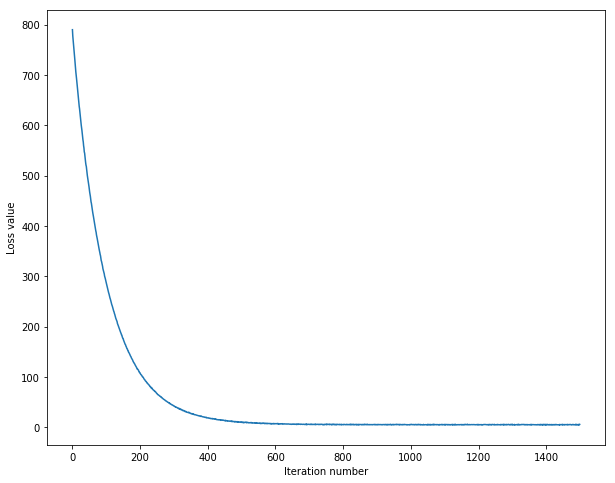

In [56]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [59]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369020
validation accuracy: 0.361000


In [65]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8,1e-7,2e-7,1e-6,5e-6]
regularization_strengths = [1e3,2.5e4,3e4,5e4,1e5,2e5,5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:        
        dev_svm = LinearSVM()
        dev_svm.train(X_train, y_train, learning_rate=learning_rate, 
                      reg=reg,num_iters=800, verbose=False)
        y_train_pred = dev_svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = dev_svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(learning_rate,reg)] = (train_accuracy,val_accuracy)
        if(val_accuracy > best_val):
            best_svm = dev_svm
            best_val = val_accuracy
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\yushe\AnacondaProjects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:113: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\yushe\AnacondaProjects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:113: RuntimeWarning: overflow encountered in multiply
  
C:\Users\yushe\AnacondaProjects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:114: RuntimeWarning: overflow encountered in multiply
  
C:\Users\yushe\AnacondaProjects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:91: RuntimeWarning: invalid value encountered in subtract
  dW_j = np.dot(mask, X.T)
C:\Users\yushe\AnacondaProjects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:92: RuntimeWarning: invalid value encountered in greater
  dW +=  dW_j
C:\Users\yushe\AnacondaProjects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:109: RuntimeWarning: invalid value encountered in multiply
  dW = dW.T
C:\Users\yushe\AnacondaProjects\cs231n\assignment1\cs231n\classifiers\linear_classifier.py:7

lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.183122 val accuracy: 0.198000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.218796 val accuracy: 0.216000
lr 1.000000e-08 reg 3.000000e+04 train accuracy: 0.212184 val accuracy: 0.218000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.232878 val accuracy: 0.238000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.274388 val accuracy: 0.291000
lr 1.000000e-08 reg 2.000000e+05 train accuracy: 0.323918 val accuracy: 0.338000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.306265 val accuracy: 0.333000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.291204 val accuracy: 0.305000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370265 val accuracy: 0.393000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.367510 val accuracy: 0.374000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.353755 val accuracy: 0.348000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.343327 val accuracy: 0.351000
lr 1.000000e-07 reg 2.000000

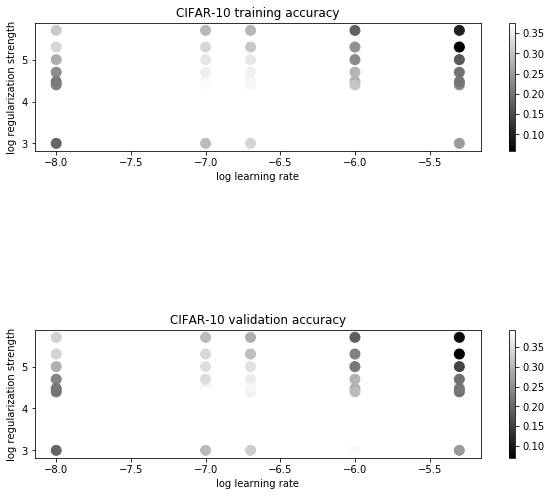

In [67]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(3, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(3, 1, 3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [68]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


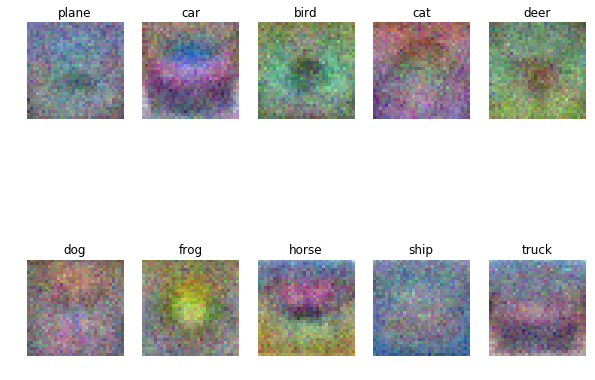

In [70]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg =  (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg)
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

**Your answer:** it looks like multple objects in one picture, I think it's in order to make sure different pictures dipicting the same catagories all have high activat